# Seminar. Unconditional Generation on Simple Cases

Here we will implement VAE on 1D simple case for discrete and continuous distributions.

* Train:
  * Loss
* Inference:
  * Sampling process
  * Evaluation Metric

## Simple 1D distributions

### Discrete distributions

1. Bernoulli Distribution
2. Categorical Distribution (Generalized Bernoulli)
3. Binomial Distribution
4. Poisson Distribution

#### 1. Bernoulli Distribution

There are two possible outcomes.



##### **PMF and CDF**

* **Probability Mass Function (PMF)**:
$$P(X = k) = p^k * (1-p)^{1-k} \space \text{for} \space k ∈ {0, 1}$$

$$P(X = 1) = p   \space \space \space \space  \text{(success)} $$
$$P(X = 0) = 1 - p \space \space \space \space \text{  (failure)}$$
* **Cumulative Distribution Function (CDF)**:
$$F(x) = P(X ≤ x) = ∑_{k ≤ x} P(X = k)$$

##### **How can we sample distribution?**

Sampling means: generate concrete values that follow the distribution's rules.

**Method 1.** **Inverse Transform Sampling**

If you can invert the CDF, you can transform uniform samples.

**Method 2.** **Rejection Sampling.**

"Propose and reject" method - works when you can't invert CDF easily.

**Disclaimer**. Yes, you can know the PDF/PMF perfectly but still not know how to generate samples efficiently.



sample from numpy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def sample_bernoulli_numpy(p, size=1):
    """Sample from Bernoulli using NumPy"""
    return np.random.binomial(1, p, size)

# Example usage
p = 0.7
samples = sample_bernoulli_numpy(p, 1000)
print(f"Generated {len(samples)} samples from Bernoulli(p={p})")
print(f"First 10 samples: {samples[:10]}")
print(f"Proportion of 1s: {np.mean(samples):.3f} (target: {p})")

Generated 1000 samples from Bernoulli(p=0.7)
First 10 samples: [1 1 0 1 0 1 0 0 1 1]
Proportion of 1s: 0.711 (target: 0.7)


**Method 1.** **Inverse Transform Sampling**

The General Algorithm

For a discrete random variable $X$ with PMF $P(X = xᵢ) = pᵢ$:

1. Generate $u \sim Uniform(0,1)$

2. Find the smallest $k$ such that $F(xₖ) ≥ u$

3. Return xₖ

where $F(x)$ is the cumulative distribution function (CDF).

In [ ]:
def sample_bernoulli_uniform(p, size=1):
    """Sample from Bernoulli using uniform distribution (inverse transform)"""
    # Step 1.
    u = np.random.uniform(0, 1, size)
    # Step 2.
    x_k = (u < p).astype(int)
    # Step 3
    return x_k

# Example usage
p = 0.7
samples = sample_bernoulli_uniform(p, 1000)
print(f"\nUsing uniform transform:")
print(f"Proportion of 1s: {np.mean(samples):.3f} (target: {p})")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sample_bernoulli_inverse(p, size=1):
    """Sample from Bernoulli using inverse transform"""
    u = np.random.uniform(0, 1, size)
    return (u > (1 - p)).astype(int)

# Let's visualize the process
p = 0.7
q = 1 - p  # = 0.3

print("=== Bernoulli Inverse Transform ===")
print(f"P(X=0) = {q:.2f}, P(X=1) = {p:.2f}")
print(f"Threshold: u ≤ {q:.2f} → X=0, u > {q:.2f} → X=1")

# Generate some samples and show the process
np.random.seed(42)
u_samples = np.random.uniform(0, 1, 10)
x_samples = (u_samples > q).astype(int)

print("\nSampling process:")
print("u (uniform) | Decision      | X (bernoulli)")
print("-------------|---------------|-------------")
for u, x in zip(u_samples, x_samples):
    decision = "u ≤ 0.3 → X=0" if u <= q else "u > 0.3 → X=1"
    print(f"  {u:.4f}    | {decision:13} |      {x}")

=== Bernoulli Inverse Transform ===
P(X=0) = 0.30, P(X=1) = 0.70
Threshold: u ≤ 0.30 → X=0, u > 0.30 → X=1

Sampling process:
u (uniform) | Decision      | X (bernoulli)
-------------|---------------|-------------
  0.3745    | u > 0.3 → X=1 |      1
  0.9507    | u > 0.3 → X=1 |      1
  0.7320    | u > 0.3 → X=1 |      1
  0.5987    | u > 0.3 → X=1 |      1
  0.1560    | u ≤ 0.3 → X=0 |      0
  0.1560    | u ≤ 0.3 → X=0 |      0
  0.0581    | u ≤ 0.3 → X=0 |      0
  0.8662    | u > 0.3 → X=1 |      1
  0.6011    | u > 0.3 → X=1 |      1
  0.7081    | u > 0.3 → X=1 |      1


### Continuous distributions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time
from IPython.display import clear_output

from sklearn.decomposition import PCA
import scipy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# <span style="color:red"> No! </span>

## 1D case

Let's understand how we can use these formulars of VAE.

### Bernoulli Distribution

#### Step 1. Generate Training Data

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def plot_bernoulli_pmf(p):
    """Plot the Bernoulli PMF"""
    plt.figure(figsize=(8, 6))

    values = [0, 1]
    probabilities = [1-p, p]

    plt.stem(values, probabilities, linefmt='b-', markerfmt='bo', basefmt=' ')
    plt.xticks([0, 1], ['0 (Failure)', '1 (Success)'])
    plt.ylabel('Probability')
    plt.ylim(0, 1.0)
    plt.title(f'Bernoulli PMF: p = {p}')
    plt.grid(True, alpha=0.3)

    # Add probability labels
    for i, (x, prob) in enumerate(zip(values, probabilities)):
        plt.text(x, prob + 0.03, f'{prob:.2f}', ha='center', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Generate training data from Bernoulli distribution
def generate_bernoulli_data(p, n_samples):
    """Generate samples from Bernoulli distribution"""
    # Convert to PyTorch tensor and reshape for VAE (batch_size, 1)
    samples = torch.bernoulli(torch.tensor(p).repeat(n_samples)).float().unsqueeze(1)
    return samples

=== Target Bernoulli Distribution ===


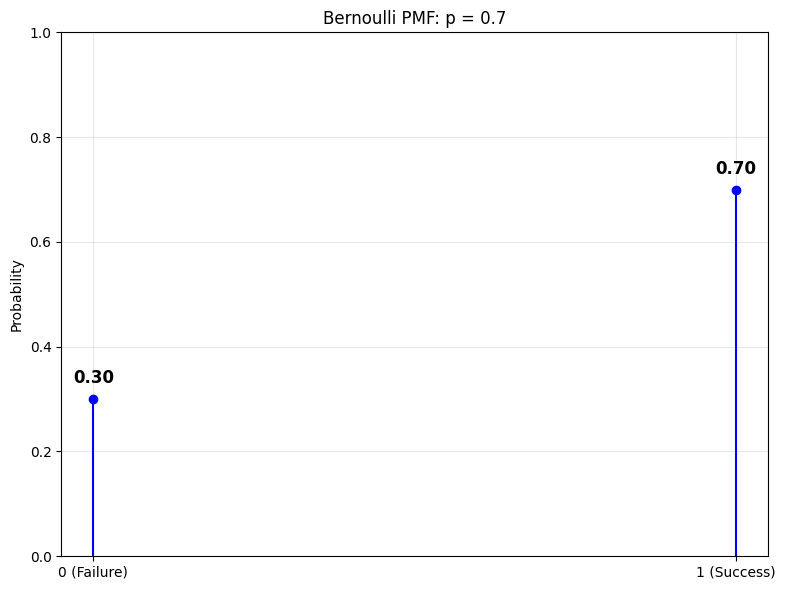

Generated 10000 training samples
Empirical probability of 1: 0.700 (target: 0.7)


In [ ]:
# Parameters
p_true = 0.7  # True probability of success
n_train = 10000  # Number of training samples

# Plot the target distribution
print("=== Target Bernoulli Distribution ===")
plot_bernoulli_pmf(p_true)

# Generate training data
train_data = generate_bernoulli_data(p_true, n_train)
print(f"Generated {len(train_data)} training samples")
print(f"Empirical probability of 1: {torch.mean(train_data).item():.3f} (target: {p_true})")

# Create DataLoader
batch_size = 128
train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)

#### Step 2: Build the VAE for Bernoulli Data

Encoder input --> [batch_size, input_dim]:
* 1D: [batch_size, 1] --> x = [x1]
* 2D: [batch_size, 2] --> x = [x1, x2]
* Image: [batch_size, n_channels, height, width]
  * Example: [batch_size, 3, h, w]


Encoder otuput --> [batch_size, 2 * z_dim]:
* 1D:



z = [z1, z2, z3,...]

Each component is sampled from its own gaussian disgtribution independently.

Reconstruction loss:

$$p(x) = p^x * (1-p)^{1-x}$$

$$log p(x) = x * log(p) + (1-x) * log(1-p)$$

$$-log p(x) = -[x * log(p) + (1-x) * log(1-p)]$$

This is exactly the **binary cross-entropy**.

KL divergence:

We have:

q(z|x) = N(μ, σ²) - our approximate posterior (diagonal covariance)

p(z) = N(0, I) - the prior (standard normal)

The general formula for KL divergence between two multivariate Gaussians is:

$$KL(q || p) = ½[tr(Σ_p⁻¹Σ_q) + (μ_p - μ_q)ᵀΣ_p⁻¹(μ_p - μ_q) - k + ln(det(Σ_p)/det(Σ_q))]$$

But since we have diagonal covariances, this simplifies dramatically!

General formula for univariate Gaussians:

$$KL(q||p) = log(σ_p/σ_q) + (σ_q² + (μ_q - μ_p)²)/(2σ_p²) - ½$$

Substitute our values (μ_p=0, σ_p²=1):

$$KL(q||p) = log(1/σ_q) + (σ_q² + μ_q²)/2 - ½ = -log(σ_q) + (σ_q² + μ_q²)/2 - ½$$

$$logvar = log(σ²) = 2*log(σ)$$

$$log(σ) = 0.5 * logvar$$

$$-log(σ_q) = -0.5 * logvar$$

$$KL = -0.5 * logvar + 0.5*(σ² + μ²) - 0.5 = = -0.5 * (1 + logvar - μ² - exp(logvar))$$




In [ ]:
# kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [ ]:
class BernoulliVAE(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=20, latent_dim=2):
        super(BernoulliVAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder: x -> μ, logσ²
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)  # Output: μ and logσ² #
        )

        # Decoder: z -> p (probability of success)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
         nn.Sigmoid()  # Output probability in [0,1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar
    # z = mu + sigma * eps, eps ~ N(0, I)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar) # σ = exp(0.5 * log(σ²))
        eps = torch.randn_like(std) # ε ~ N(0, 1) - PURE RANDOMNESS
        return mu + eps * std # z = μ + σ ⊙ ε

    def decode(self, z):
        return self.decoder(z)  # Returns p (probability)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        p_recon = self.decode(z)
        return p_recon, mu, logvar, z

def bernoulli_vae_loss(recon_p, x, mu, logvar):
    """
    VAE loss for Bernoulli data
    Reconstruction loss: Bernoulli negative log likelihood
    """
    # Reconstruction loss: -log p(x|z) = -[x*log(p) + (1-x)*log(1-p)]
    recon_loss = F.binary_cross_entropy(recon_p, x, reduction='sum')

    # KL divergence: KL(q(z|x) || N(0,I))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

#### Step 3: Train the VAE

In [ ]:
def train_bernoulli_vae(model, train_loader, epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []
    recon_losses = []
    kl_losses = []

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0
        num_batches = 0

        for batch in train_loader:
            x = batch[0]
            optimizer.zero_grad()

            p_recon, mu, logvar, z = model(x)
            loss, recon_loss, kl_loss = bernoulli_vae_loss(p_recon, x, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
            num_batches += 1

        avg_loss = total_loss / len(train_loader.dataset)
        avg_recon = total_recon / len(train_loader.dataset)
        avg_kl = total_kl / len(train_loader.dataset)

        train_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)

        if epoch % 200 == 0:
            print(f'Epoch {epoch:4d}: Loss = {avg_loss:.4f}, '
                  f'Recon = {avg_recon:.4f}, KL = {avg_kl:.4f}')

    return train_losses, recon_losses, kl_losses

# Initialize and train the VAE
model = BernoulliVAE(input_dim=1, hidden_dim=20, latent_dim=2)
print("\n=== Training VAE ===")
train_losses, recon_losses, kl_losses = train_bernoulli_vae(model, train_loader, epochs=2000)


=== Training VAE ===
Epoch    0: Loss = 0.6540, Recon = 0.6331, KL = 0.0209
Epoch  200: Loss = 0.6109, Recon = 0.6054, KL = 0.0055
Epoch  400: Loss = 0.6110, Recon = 0.6106, KL = 0.0004
Epoch  600: Loss = 0.6103, Recon = 0.6064, KL = 0.0040
Epoch  800: Loss = 0.6107, Recon = 0.6076, KL = 0.0031
Epoch 1000: Loss = 0.6100, Recon = 0.6051, KL = 0.0049
Epoch 1200: Loss = 0.6111, Recon = 0.6084, KL = 0.0027
Epoch 1400: Loss = 0.6111, Recon = 0.6104, KL = 0.0008
Epoch 1600: Loss = 0.6106, Recon = 0.6093, KL = 0.0013
Epoch 1800: Loss = 0.6105, Recon = 0.6097, KL = 0.0008


#### Step 4: Visualize Training Progress

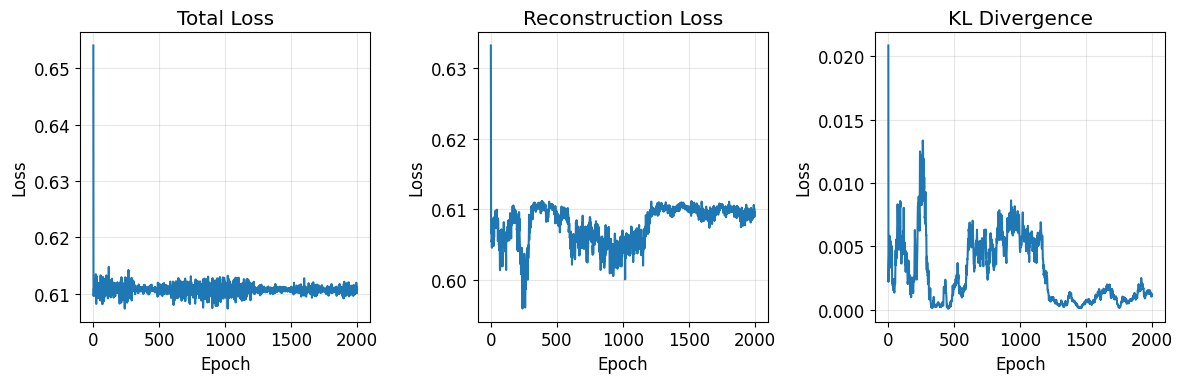

In [ ]:
def plot_training_progress(train_losses, recon_losses, kl_losses):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(recon_losses)
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(kl_losses)
    plt.title('KL Divergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_progress(train_losses, recon_losses, kl_losses)

#### Step 5: Analyze the Trained VAE


=== Analyzing Trained VAE ===
Original data - p(1): 0.7003
Generated samples - p(1): 0.7000
Reconstructed samples - p(1): 0.7210


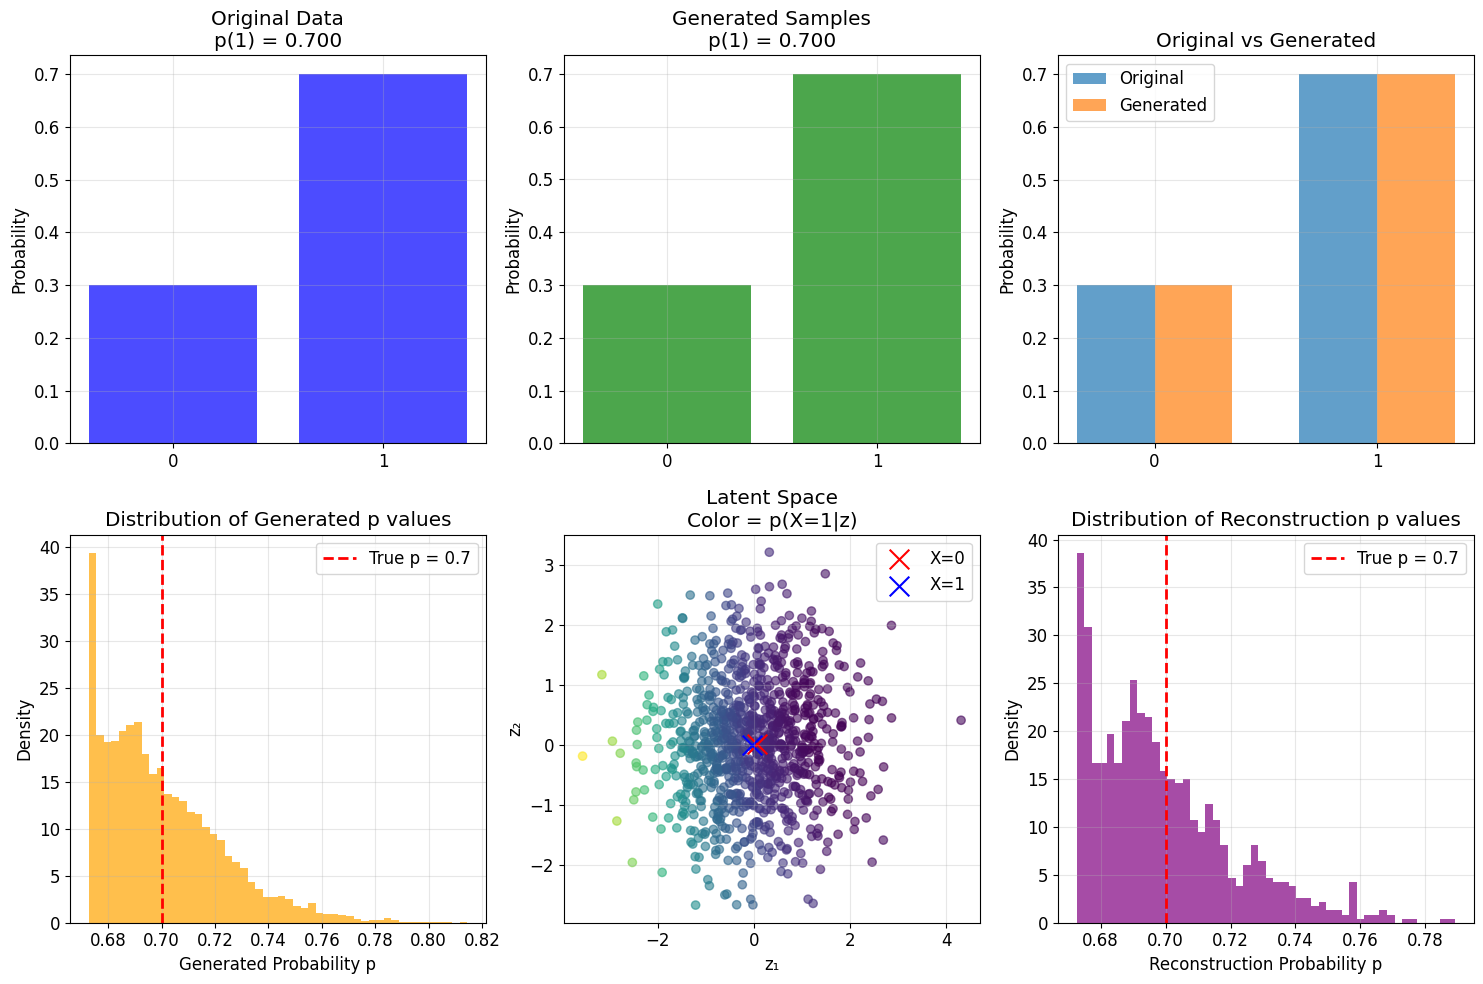

In [ ]:
def analyze_trained_vae(model, true_p, n_samples=10000):
    """Analyze the trained VAE's generation capabilities"""

    model.eval()

    with torch.no_grad():
        # Method 1: Sample from the VAE
        z_samples = torch.randn(n_samples, model.latent_dim)
        p_generated = model.decode(z_samples)

        # Convert probabilities to binary samples
        generated_samples = torch.bernoulli(p_generated)

        # Method 2: Look at reconstruction quality
        test_data = generate_bernoulli_data(true_p, 1000)
        p_recon, mu, logvar, z = model(test_data)
        reconstructed_samples = torch.bernoulli(p_recon)

    return generated_samples, reconstructed_samples, p_generated, p_recon

def plot_vae_results(true_p, generated_samples, reconstructed_samples,
                    p_generated, p_recon, original_data):
    """Plot comprehensive results of the trained VAE"""

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot 1: Original data distribution
    original_probs = [1 - torch.mean(original_data).item(), torch.mean(original_data).item()]
    axes[0, 0].bar([0, 1], original_probs, alpha=0.7, color='blue', label='Original')
    axes[0, 0].set_xticks([0, 1])
    axes[0, 0].set_xticklabels(['0', '1'])
    axes[0, 0].set_ylabel('Probability')
    axes[0, 0].set_title(f'Original Data\np(1) = {original_probs[1]:.3f}')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Generated samples distribution
    gen_probs = [1 - torch.mean(generated_samples).item(), torch.mean(generated_samples).item()]
    axes[0, 1].bar([0, 1], gen_probs, alpha=0.7, color='green', label='Generated')
    axes[0, 1].set_xticks([0, 1])
    axes[0, 1].set_xticklabels(['0', '1'])
    axes[0, 1].set_ylabel('Probability')
    axes[0, 1].set_title(f'Generated Samples\np(1) = {gen_probs[1]:.3f}')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Comparison
    width = 0.35
    x_pos = np.arange(2)
    axes[0, 2].bar(x_pos - width/2, original_probs, width, label='Original', alpha=0.7)
    axes[0, 2].bar(x_pos + width/2, gen_probs, width, label='Generated', alpha=0.7)
    axes[0, 2].set_xticks(x_pos)
    axes[0, 2].set_xticklabels(['0', '1'])
    axes[0, 2].set_ylabel('Probability')
    axes[0, 2].set_title('Original vs Generated')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Plot 4: Distribution of generated probabilities p
    axes[1, 0].hist(p_generated.numpy(), bins=50, alpha=0.7, color='orange', density=True)
    axes[1, 0].axvline(x=true_p, color='red', linestyle='--', linewidth=2,
                      label=f'True p = {true_p}')
    axes[1, 0].set_xlabel('Generated Probability p')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Distribution of Generated p values')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 5: Latent space visualization
    with torch.no_grad():
        # Encode some data to see latent space
        test_points = torch.tensor([[0.0], [1.0]]).float()
        mu, _ = model.encode(test_points)

        # Sample some points in latent space
        z_grid = torch.randn(1000, 2)
        p_grid = model.decode(z_grid)

    axes[1, 1].scatter(z_grid[:, 0], z_grid[:, 1], c=p_grid.numpy(), cmap='viridis', alpha=0.6)
    axes[1, 1].scatter(mu[0, 0], mu[0, 1], marker='x', s=200, color='red', label='X=0')
    axes[1, 1].scatter(mu[1, 0], mu[1, 1], marker='x', s=200, color='blue', label='X=1')
    axes[1, 1].set_xlabel('z₁')
    axes[1, 1].set_ylabel('z₂')
    axes[1, 1].set_title('Latent Space\nColor = p(X=1|z)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Plot 6: Reconstruction probabilities
    axes[1, 2].hist(p_recon.numpy(), bins=50, alpha=0.7, color='purple', density=True)
    axes[1, 2].axvline(x=true_p, color='red', linestyle='--', linewidth=2,
                      label=f'True p = {true_p}')
    axes[1, 2].set_xlabel('Reconstruction Probability p')
    axes[1, 2].set_ylabel('Density')
    axes[1, 2].set_title('Distribution of Reconstruction p values')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Analyze the trained model
print("\n=== Analyzing Trained VAE ===")
generated_samples, reconstructed_samples, p_generated, p_recon = analyze_trained_vae(model, p_true)

print(f"Original data - p(1): {torch.mean(train_data).item():.4f}")
print(f"Generated samples - p(1): {torch.mean(generated_samples).item():.4f}")
print(f"Reconstructed samples - p(1): {torch.mean(reconstructed_samples).item():.4f}")

plot_vae_results(p_true, generated_samples, reconstructed_samples,
                p_generated, p_recon, train_data)

## 2D case

### GMM

In [ ]:
class GMM(nn.Module):

    @property
    def mu(self):
        return self._mu

    @mu.setter
    def mu(self, val):
        self._mu = nn.Parameter(val)

    @property
    def sigma(self):
        return self._L @ self._L.transpose(1, 2)

    @sigma.setter
    def sigma(self, val):
        self._L = nn.Parameter(torch.cholesky(val))

    @property
    def pi(self):
        return F.softmax(self._log_pi)

    @pi.setter
    def pi(self, val):
        assert val.min() > 0.
        val = val/torch.sum(val)
        self._log_pi = nn.Parameter(torch.log(val))

    @property
    def gmm(self):
        mix = TD.Categorical(self.pi)
        mv_normals = TD.MultivariateNormal(self.mu, scale_tril=self._L)
        gmm = TD.MixtureSameFamily(mix, mv_normals)
        return gmm

    def __init__(self, K, dim, mu=None, sigma=None, pi=None):
        '''
        Define a model with known number of clusters and dimensions.
        :Parameters:
            - K: Number of Gaussian clusters
            - dim: Dimension
            - mu: means of clusters (K, dim)
                       (default) random from uniform[-10, 10]
            - sigma: covariance matrices of clusters (K, dim, dim)
                          (default) Identity matrix for each cluster
            - pi: cluster weights (K,)
                       (default) equal value to all cluster i.e. 1/K
        '''
        super().__init__()
        self.K = K
        self.dim = dim
        if mu is None:
            mu = np.random.rand(K, dim)*20 - 10
        self.mu = torch.tensor(mu) # (K, D)
        if sigma is None :
            sigma = np.zeros((K, dim, dim))
            for i in range(K):
                sigma[i] = np.eye(dim)
        self.sigma = torch.tensor(sigma) # (K, D, D)
        assert torch.allclose(self.sigma, torch.tensor(sigma))
        if pi is None:
            pi = np.ones(self.K)/self.K
        self.pi = torch.tensor(pi) # (K,)
        # mix = TD.Categorical(self.pi)
        # mv_normals = TD.MultivariateNormal(self.mu, scale_tril=self.sigma)
        # self.gmm = TD.MixtureSameFamily(mix, mv_normals)
#         self.gmm = TD.MultivariateNormal(self.mu, self.sigma)

    def log_prob(self, X):
        '''
        Compute the log-prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: log Sum_k pi_k * N( X_i | mu_k, sigma_k ))
        '''
        return self.gmm.log_prob(X)

    def prob(self, X):
        '''
        Computes the prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: Sum_k pi_k * N( X_i | mu_k, sigma_k )
        '''
        return torch.exp(self.log_prob(X))

    def prob_X_Zs(self, X):
        '''
        Computes the matrix of probabilities p(X, Z | \theta)
        for all possible Z_i \in \{1, 2, \dots K\}
        :Parameters:
        X : tensor (N, D)
        :Output:
        out : tensor (N, K)
        '''
        mv_normals = self.gmm._component_distribution
        X_expanded = X.unsqueeze(-2).repeat(1, self.K, 1) # (N, K, 2)
        log_probs_unw = mv_normals.log_prob(X_expanded) # (N, K)
        log_probs_w = torch.exp(log_probs_unw) * self.pi.unsqueeze(0) # (N, K)
        return log_probs_w

    def sample(self, shape):
        return self.gmm.sample(shape)

In [ ]:
def draw_contour(density, X, Y, title, n_levels=3):
    plt.figure(figsize=(5, 5))
    density = density.reshape(X.shape)
    levels = np.linspace(np.min(density), np.max(density), n_levels)
    plt.contour(X, Y, density, levels=levels, c='red')
    plt.title(title, fontsize=16)
    plt.show()

def draw_distrib(distrib, title, n_levels=20, x_lim=(-11, 11), y_lim=(-11, 11), dx=0.1, dy=0.1, device=DEVICE, contour=True, density=True):
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
    densities = torch.exp(distrib.log_prob(torch.tensor(mesh_xs).to(device))).detach().cpu().numpy()
    if contour:
        draw_contour(densities, x, y, title='{} contour'.format(title), n_levels=20)
    if density:
        visualize_2d_densities(x, y, densities, title='{} pdf'.format(title))

In [ ]:
class FlowerGMM(GMM):

    def __init__(self):
        CENTERS_SCALE = 6.
        MAJOR_VAR = 3.
        MINOR_VAR = 1.
        r_angles = np.linspace(0., 2 * np.pi, 7, endpoint=False)
        vs = np.array([[np.cos(ang), np.sin(ang)] for ang in r_angles])
        perp_vs = np.array([[-np.sin(ang), np.cos(ang)] for ang in r_angles])
        mus = np.array([[0., 0.],] + [CENTERS_SCALE * v for v in vs])
        R_matrices = np.stack([vs, perp_vs], axis=1)
        petal_sigmas = np.array([[MAJOR_VAR, 0.], [0., MINOR_VAR]])[np.newaxis,...].repeat(7, axis=0)
        sigmas = np.concatenate([
            np.eye(2)[np.newaxis,...],
            R_matrices.transpose(0, 2, 1) @ petal_sigmas @ R_matrices])
        super().__init__(8, 2, mu=mus, sigma=sigmas)
        # super().__init__(1, 2)

In [ ]:
fgmm = FlowerGMM().to(DEVICE)
draw_distrib(fgmm, 'FlowerGMM')

In [ ]:
torch.manual_seed(42)
train_data = fgmm.sample((20000,)).detach()
test_data = fgmm.sample((2000,)).detach()